# Implementing a Convolutional Neural Network (CNN) + Long Short-Term Memory (LSTM) Model for URL Classification

## Introduction
In this notebook, we’ll implement a hybrid model combining **Convolutional Neural Networks (CNN)** and **Long Short-Term Memory (LSTM)** layers to classify URLs as either malicious or benign.

- CNN is great for capturing local patterns within URLs, like detecting commonly used words or structures in malicious URLs.
- LSTM is designed to handle sequence dependencies, making it suitable for understanding the overall structure of URLs.

Our goal is to build a model that can accurately classify URLs by learning these patterns and dependencies. This project will walk you through data loading, preprocessing, model building, training, and evaluation.


In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

# Text preprocessing and encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model-related libraries (CNN + LSTM architecture and layers)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Model evaluation and metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.model_selection import KFold

# Plotting library for visualizing performance
import matplotlib.pyplot as plt

# Utility libraries for text processing and operating system functionality
import re
import os


## Accessing the Dataset

### Current Setup (For My Google Drive)

At the moment, I am running this notebook on **Google Colab** and accessing the dataset directly from my personal **Google Drive**. The data is located in a specific folder in my Drive, and I use `drive.mount()` to access it.

### Instructions for Other Users

- **Google Colab Users**: If you’re using **Google Colab**, you will need to mount your own Google Drive and update the file path to match where the dataset is stored in your Drive.
  
  Replace the path `'/content/drive/My Drive/N Task'` with the path to your dataset in your own Drive.
  
- **Local Machine Users**: If you're running this notebook on your local machine, place the dataset in the same directory as this notebook or specify the path where the dataset is stored on your system.

In the code block below, I will provide the current setup I'm using with my Drive and show how you can modify it for your own setup.


In [13]:
# --- My Current Setup in Google Colab (Using my personal Google Drive) --- #
from google.colab import drive
drive.mount('/content/drive')

# My Google Drive path (this will not work for others unless they have the exact same structure)
os.chdir('/content/drive/My Drive/N Task')

# Load the dataset from my Google Drive
df = pd.read_csv('Randomized_TestData_Harmful_and_Harmless_URLs.csv')

# --- Instructions for Users --- #
# 1. If you're using Google Colab with your own Google Drive:
#    Replace '/content/drive/My Drive/N Task' with the path to the dataset in YOUR Google Drive.
#    Example:
#    os.chdir('/content/drive/My Drive/path_to_your_data')

# 2. If you're running this notebook on your local machine:
#    Comment out the above lines related to Google Drive and load the file directly from your system.
#    Example:
#    df = pd.read_csv('path_to_your_local_file.csv')

# Display the first few rows of the dataset
print(df.head(50))
print(df.info())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                  URL                Label
0      https://autopartsandequipment.com/tag/bluetec/             Harmless
1                    http://42.226.66.30:52165/Mozi.m              Malware
2    http://mail.sitefind.top:8888/22509121009108.dll              Malware
3   https://www.register-yacht-seychelles.com/de/b...             Harmless
4   https://www.bwjunior.hants.sch.uk/about-the-sc...             Harmless
5   https://www.paragraf.ba/dnevne-vijesti/2407202...             Harmless
6   https://mail.openjdk.org/pipermail/jextract-de...             Harmless
7               http://gloomcutter.shop:8888/3608.dll              Malware
8   https://www.urday.in/szampon-do-wosuw-maroccan...             Harmless
9                  http://wordmover.shop:8888/259.dll              Malware
10        https://abelard.org/news/politics032

## Step 2: Label Mapping and Categorization

In this step, we will examine the unique categories (or labels) present in the dataset. These labels represent the classification of URLs into categories such as **Harmless**, **Malware**, **Phishing**, etc.

To enhance the interpretability of the dataset, we will map these labels to more descriptive risk levels that reflect the likelihood of malicious activity. This will provide clearer insights into the severity of each label.

After the mapping is completed, we will count the occurrences of each label to understand the distribution of risk levels in the dataset.

In [14]:
# Retrieve and display the unique categories present in the 'Label' column
unique_labels = df['Label'].unique()
print("Unique categories in the 'Label' column:", unique_labels)

# Define a function to map the original labels to professionally categorized risk levels
def map_label_to_risk_professional(label):
    """
    Maps the original label to a formalized risk level description.

    - 'Harmless': Represents no significant risk (0% - 1% probability of phishing).
    - 'Phishing': Represents moderate risk (40% - 60% probability of phishing).
    - 'Malware' and 'Definitely Phishing': Represents critical risk (60% - 100% probability of phishing).
    - 'Suspicious' and 'Likely': Represents low risk (1% - 40% probability of phishing).
    - 'Unknown': Represents instances where the label is not identified.

    Parameters:
    label (str): The original label from the dataset.

    Returns:
    str: A professional description of the risk level.
    """
    if label in ['Harmless']:
        return 'No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)'
    elif label in ['Phishing']:
        return 'High Risk (Elevated concern: 40% - 60% probability of phishing activity)'
    elif label in ['Definitely Phishing', 'Malware']:
        return 'Critical Threat - Harmful (Severe risk: 60% - 100% likelihood of phishing)'
    elif label in ['Suspicious', 'Likely']:
        return 'Low Risk (Low concern: 1% - 40% chance of phishing)'
    else:
        return 'Unknown (Probability not determined)'

# Apply the mapping function to the 'Label' column, updating the risk categories with professional descriptions
df['Label'] = df['Label'].apply(map_label_to_risk_professional)

# Display the updated unique categories in the 'Label' column after the mapping
updated_labels = df['Label'].unique()
print("Updated categories in the 'Label' column:", updated_labels)

# Count and display the occurrences of each risk level in the dataset
label_counts = df['Label'].value_counts()
print("Number of occurrences for each label after mapping:")
print(label_counts)


Unique categories in the 'Label' column: ['Harmless' 'Malware' 'Phishing' 'Definitely Phishing' 'Suspicious'
 'Likely']
Updated categories in the 'Label' column: ['No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)'
 'Critical Threat - Harmful (Severe risk: 60% - 100% likelihood of phishing)'
 'High Risk (Elevated concern: 40% - 60% probability of phishing activity)'
 'Low Risk (Low concern: 1% - 40% chance of phishing)']
Number of occurrences for each label after mapping:
Label
No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)    787152
Critical Threat - Harmful (Severe risk: 60% - 100% likelihood of phishing)    282155
Low Risk (Low concern: 1% - 40% chance of phishing)                            25594
High Risk (Elevated concern: 40% - 60% probability of phishing activity)       16892
Name: count, dtype: int64


## Step 3: Feature Extraction from URLs

In this section, we will extract specific features from the URLs to enhance the model's ability to differentiate between malicious and benign URLs.

We will derive the following features:
1. **URL Length**: The total length of the URL. Longer URLs can sometimes indicate phishing attempts.
2. **Number of Special Characters**: The count of special characters such as `?`, `&`, `$`, etc., which may signify complex or suspicious URL patterns.
3. **Presence of Suspicious Substrings**: We will check if certain keywords like "login", "secure", "paypal", or "bank" are present, which may hint at phishing behavior.
4. **Use of HTTPS**: We will identify whether the URL starts with "https", which is generally a sign of a secure connection.

Once these features are extracted, we will combine them with the existing dataset to create a more comprehensive representation for the model.


In [15]:
# Improved function to extract features from a URL, with additional checks for accuracy
def extract_url_features(url):
    features = {}

    # Feature 1: URL length categorized into 'short', 'medium', and 'long'
    url_length = len(url)
    if url_length < 50:
        features['url_length_category'] = 'short'
    elif 50 <= url_length <= 100:
        features['url_length_category'] = 'medium'
    else:
        features['url_length_category'] = 'long'

    # Feature 2: Count different groups of special characters
    special_chars = re.findall(r'[?=&%$#]', url)
    features['special_char_count'] = len(special_chars)

    # Enhancement: Also categorize based on how many special characters are present
    if len(special_chars) == 0:
        features['special_char_category'] = 'none'
    elif 1 <= len(special_chars) <= 3:
        features['special_char_category'] = 'few'
    else:
        features['special_char_category'] = 'many'

    # Feature 3: Count of suspicious substrings, rather than just a boolean
    suspicious_substrings = ['login', 'secure', 'paypal', 'bank', 'signin', 'account', 'update', 'password', 'confirm']
    substrings_found = [substring for substring in suspicious_substrings if substring in url.lower()]
    features['suspicious_substring_count'] = len(substrings_found)

    # Enhancement: If suspicious substrings are found, list them (useful for further analysis)
    features['suspicious_substrings'] = ', '.join(substrings_found) if substrings_found else 'none'

    # Feature 4: Flag whether the URL is using HTTPS or not
    features['is_https'] = 1 if url.startswith('https') else 0

    # Enhancement: Check if the URL is "http" (insecure) and contains suspicious words like "login" or "secure"
    features['is_http_and_suspicious'] = 1 if (url.startswith('http') and any(sub in url.lower() for sub in suspicious_substrings)) else 0

    return features

# Create a DataFrame to store the extracted features for each URL in the dataset
url_features_df = pd.DataFrame([extract_url_features(url) for url in df['URL']])

# Combine the extracted features with the original dataset
df_combined = pd.concat([df, url_features_df], axis=1)

# Display the first few rows to verify the new features
print(df_combined.head())


                                                 URL  \
0     https://autopartsandequipment.com/tag/bluetec/   
1                   http://42.226.66.30:52165/Mozi.m   
2   http://mail.sitefind.top:8888/22509121009108.dll   
3  https://www.register-yacht-seychelles.com/de/b...   
4  https://www.bwjunior.hants.sch.uk/about-the-sc...   

                                               Label url_length_category  \
0  No threats - Harmless (Negligible chance: 0% -...               short   
1  Critical Threat - Harmful (Severe risk: 60% - ...               short   
2  Critical Threat - Harmful (Severe risk: 60% - ...               short   
3  No threats - Harmless (Negligible chance: 0% -...              medium   
4  No threats - Harmless (Negligible chance: 0% -...              medium   

   special_char_count special_char_category  suspicious_substring_count  \
0                   0                  none                           0   
1                   0                  none             

## Step 4: Tokenization, Feature Extraction, and Data Preparation

In this step, we will tokenize the URLs and extract additional features (such as URL length, number of special characters, and whether the URL uses HTTPS).

Once these features are extracted, we will:
1. **Tokenize the URLs**: Convert the URLs into sequences of numbers using a tokenizer, which assigns a unique number to each word/character.
2. **Extract Additional Features**: These include URL length, the count of special characters, and whether the URL uses HTTPS.
3. **Label Encoding**: Convert the labels into integers to make them ready for the model.
4. **Data Splitting**: Split the dataset into training and testing sets, using both the tokenized URLs and additional features.


In [16]:
# Tokenize the URLs, limit the vocabulary size to exclude rare words
vocab_size = 10000  # You can experiment with this value for better performance
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['URL'])
sequences = tokenizer.texts_to_sequences(df['URL'])

# Pad the sequences so they all have the same length
max_sequence_length = max([len(seq) for seq in sequences])
X_url_data = pad_sequences(sequences, maxlen=max_sequence_length)

# Advanced feature extraction for additional insights
# Feature 1: URL length, categorized into 'very short', 'short', 'medium', 'long', 'very long'
df['url_length'] = df['URL'].apply(lambda x: len(x))
df['url_length_category'] = pd.cut(df['url_length'], bins=[0, 30, 60, 100, 150, np.inf],
                                   labels=['very short', 'short', 'medium', 'long', 'very long'])

# Feature 2: Count of special characters, categorized into 'few', 'moderate', 'many'
df['num_special_chars'] = df['URL'].apply(lambda x: sum([1 for char in x if char in '!@#$%^&*()']))
df['special_char_category'] = pd.cut(df['num_special_chars'], bins=[0, 1, 3, np.inf],
                                     labels=['few', 'moderate', 'many'])

# Feature 3: Flag if the URL uses HTTPS
df['is_https'] = df['URL'].apply(lambda x: 1 if x.startswith('https') else 0)

# Feature 4: Count of suspicious substrings found in the URL
suspicious_substrings = ['login', 'secure', 'paypal', 'bank', 'signin', 'account', 'update', 'password', 'confirm']
df['suspicious_substring_count'] = df['URL'].apply(lambda x: sum([x.lower().count(sub) for sub in suspicious_substrings]))

# Create a DataFrame with the extracted additional features
x_features_data = df[['url_length', 'num_special_chars', 'is_https', 'suspicious_substring_count']].values

# Apply feature scaling to numeric features for better performance in neural networks
scaler = StandardScaler()
x_features_scaled = scaler.fit_transform(x_features_data)

# Map the labels to integers using LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Label'])

# Print the mapped labels to check the new categories
print("Encoded Label Classes:", label_encoder.classes_)

# Split the data into training and testing sets
# Use both URL sequences and the additional extracted features as inputs
X_url_train, X_url_test, x_features_train, x_features_test, y_train, y_test = train_test_split(
    X_url_data, x_features_scaled, labels, test_size=0.2, random_state=42
)

# Display the shapes of the training and testing sets to verify the split
print("URL Train Shape:", X_url_train.shape)
print("Additional Features Train Shape:", x_features_train.shape)
print("Labels Train Shape:", y_train.shape)


Encoded Label Classes: ['Critical Threat - Harmful (Severe risk: 60% - 100% likelihood of phishing)'
 'High Risk (Elevated concern: 40% - 60% probability of phishing activity)'
 'Low Risk (Low concern: 1% - 40% chance of phishing)'
 'No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)']
URL Train Shape: (889434, 653)
Additional Features Train Shape: (889434, 4)
Labels Train Shape: (889434,)


## Step 5: Model Building, Training, Evaluation, and Visualization

In this step, we define, compile, train, evaluate the model, and visualize its performance across different folds.

1. **Model Definition**:
   - The model has two input layers:
     - One for **URL sequences**, which passes through an **Embedding layer** that converts words into dense vectors.
     - The sequence data is then passed through a **Conv1D** layer to extract patterns, followed by a **MaxPooling1D** layer to reduce dimensionality.
     - We apply **BatchNormalization** to stabilize and accelerate training, and then process the data with an **LSTM layer**, which captures sequential patterns in the URL data.
     - The second input layer handles **additional features** (e.g., whether HTTPS is used, suspicious substring counts), which are concatenated with the LSTM output before the final classification layers.

2. **Training Process**:
   - The model is trained using **5 epochs** with a batch size of **128**.
   - We use **3-fold cross-validation**, splitting the data into 3 subsets to ensure the model generalizes well across different portions of the data.
   - **EarlyStopping** is used to halt training if no improvement is seen in the validation loss for 2 consecutive epochs.
   - We also employ **ReduceLROnPlateau** to lower the learning rate if the validation loss stops improving, allowing for smoother convergence and preventing overfitting.

3. **Evaluation**:
   - After training on each fold, the model is evaluated on a test set, and the **accuracy** is printed for each fold.
   - Cross-validation ensures that the model is assessed on different data splits, providing a more robust estimate of its performance.

4. **Visualization**:
   - For each fold, we plot the **training and validation accuracy** over epochs, giving insight into how well the model is learning.
   - Similarly, the **training and validation loss** is plotted to monitor the model's convergence and detect any signs of overfitting.
   - The visualizations help us understand how the model performs across different folds and how well it generalizes to unseen data.

By combining cross-validation, early stopping, and learning rate reduction, we ensure that the model generalizes well and avoids overfitting, while also providing clear visual feedback on its performance.


Epoch 1/5
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 152s 26ms/step - accuracy: 0.9624 - loss: 0.1219 - val_accuracy: 0.9720 - val_loss: 0.0811 - learning_rate: 0.0010
Epoch 2/5
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 148s 26ms/step - accuracy: 0.9752 - loss: 0.0732 - val_accuracy: 0.9752 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 3/5
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 148s 25ms/step - accuracy: 0.9761 - loss: 0.0689 - val_accuracy: 0.9757 - val_loss: 0.0722 - learning_rate: 0.0010
Epoch 4/5
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9771 - loss: 0.0653
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 148s 25ms/step - accuracy: 0.9771 - loss: 0.0653 - val_accuracy: 0.9744 - val_loss: 0.0741 - learning_rate: 0.0010
Epoch 5/5
5791/5791 ━━━━━━━━━━━━━━━━━━━━ 148s 25ms/step - accuracy: 0.9777 - loss: 0.0624 - val_accuracy: 0.9765 - val_loss: 0.0709 - learning_rate: 5.0000e-04
11582/11582 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - accuracy: 0.97

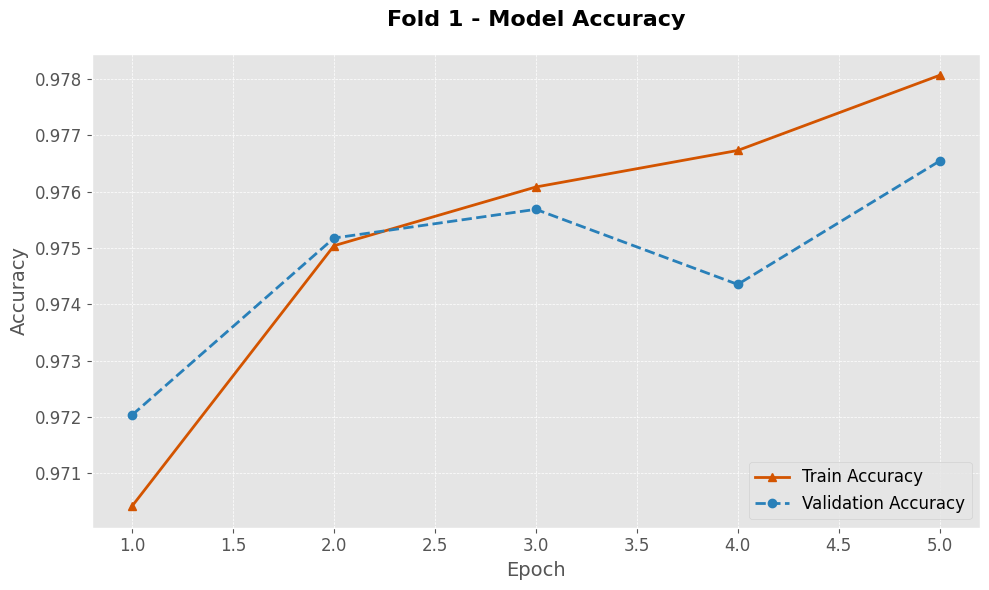

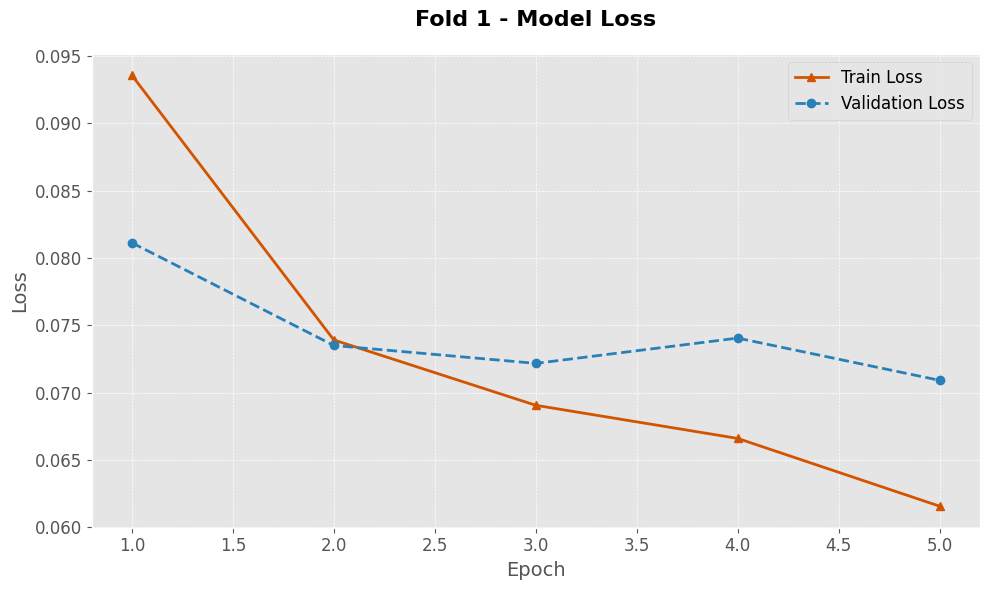

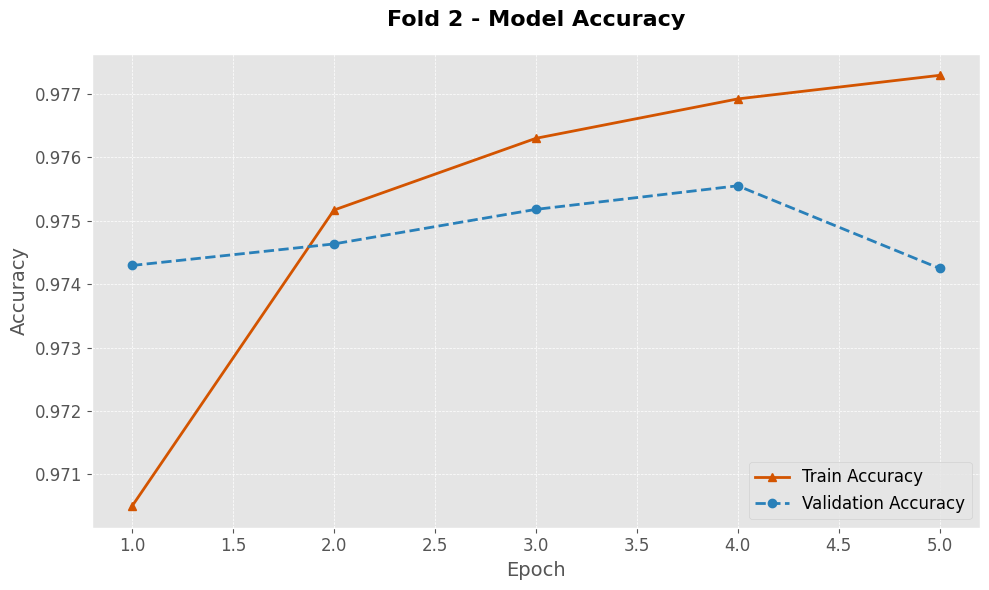

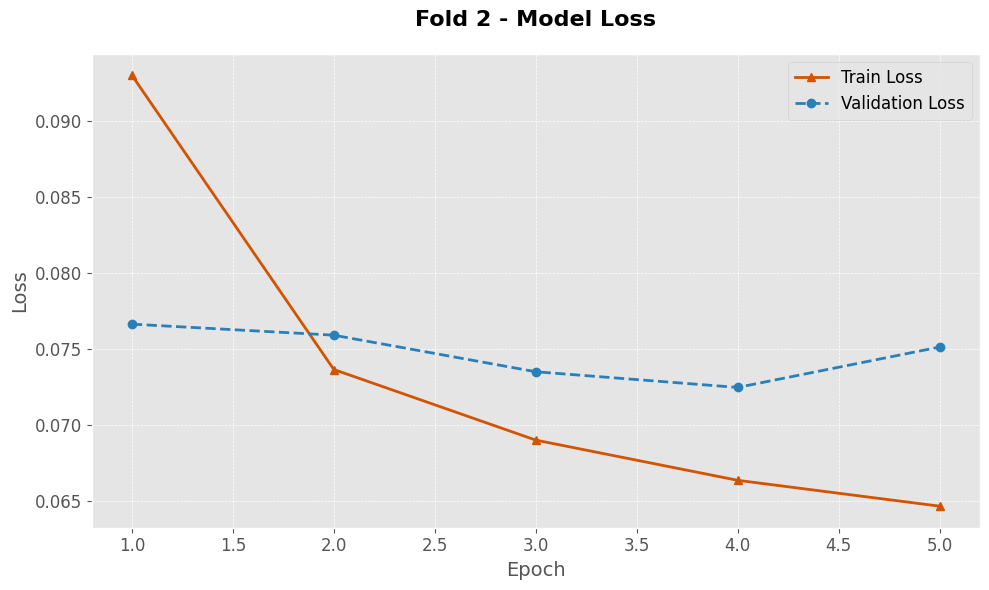

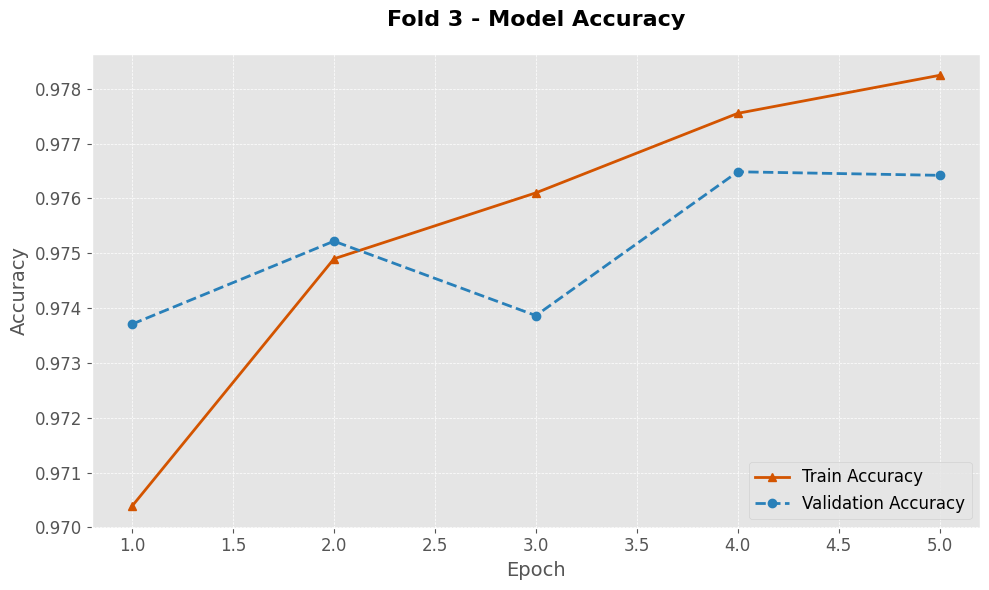

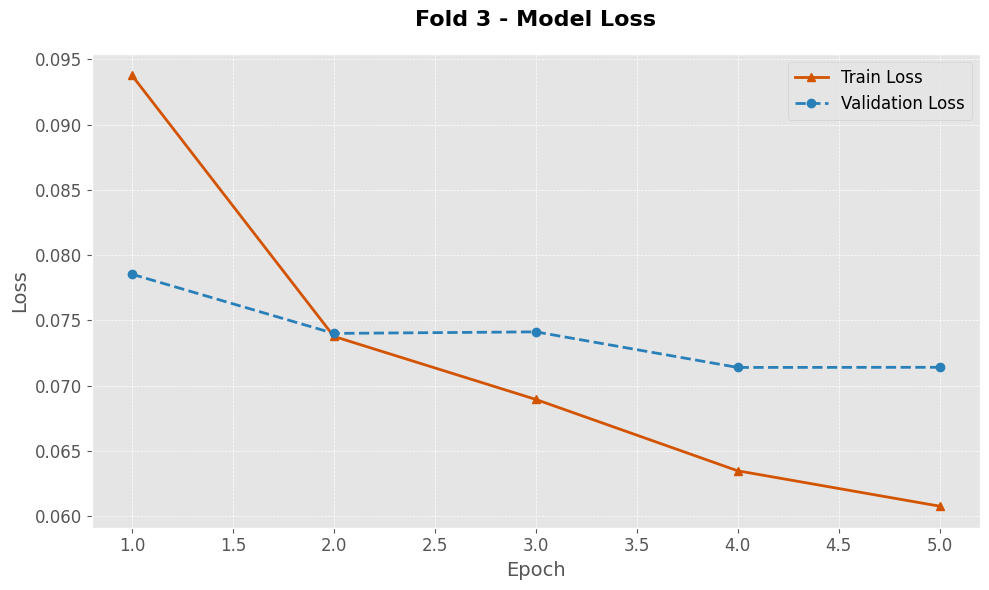

In [21]:
# Define the model building function
def build_model(learning_rate=0.001):
    # Define input layers
    url_input = Input(shape=(max_sequence_length,), name='url_input')
    features_input = Input(shape=(X_features_data.shape[1],), name='features_input')

    # Embedding and LSTM for sequence data
    x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(url_input)
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = LSTM(64)(x)  # Reduced LSTM size to 64 units
    x = Dropout(0.3)(x)

    # Concatenate LSTM output with additional features
    x = Concatenate()([x, features_input])

    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=[url_input, features_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Prepare the data
sequences = tokenizer.texts_to_sequences(df['URL'])
X_url_data = pad_sequences(sequences, maxlen=max_sequence_length)

# One-Hot Encoding for categorical features in url_features_df
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse to avoid deprecation warnings
categorical_columns = ['url_length_category', 'special_char_category']  # Replace with actual column names in your dataframe
encoded_features = encoder.fit_transform(df[categorical_columns])

# Combine encoded categorical features with other numerical features
numerical_features = df[['is_https', 'suspicious_substring_count']]  # Replace with your numerical columns
X_features_data = np.hstack([encoded_features, numerical_features.values])

# Ensure all feature data is now float32
X_features_data = np.array(X_features_data, dtype='float32')

# Encode the labels and ensure labels are integers
labels = np.array(label_encoder.fit_transform(df['Label']), dtype='int32')

# Reduce number of KFold splits to 3 and use 1 model per fold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Reduced training parameters: fewer epochs, fewer models, fewer folds
epochs = 5
batch_size = 128

# Prepare lists to store history from each fold
history_list = []

for train_idx, test_idx in kfold.split(X_url_data):
    X_url_train, X_url_test = X_url_data[train_idx], X_url_data[test_idx]
    X_features_train, X_features_test = X_features_data[train_idx], X_features_data[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model = build_model(learning_rate=0.001)

    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

    # Train the model and capture history
    history = model.fit([X_url_train, X_features_train], y_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=([X_url_test, X_features_test], y_test),
                        callbacks=[early_stopping, reduce_lr])

    # Append the history for each fold to history_list
    history_list.append(history)

    # Evaluate the model
    loss, accuracy = model.evaluate([X_url_test, X_features_test], y_test)
    print(f"Fold Test Accuracy: {accuracy}")

# Plot training and validation accuracy and loss for each fold
for i, history in enumerate(history_list):
    epochs_range = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(epochs_range, history.history['accuracy'], color='#D35400', marker='^', linestyle='-', linewidth=2, markersize=6, label='Train Accuracy')  # Training accuracy plot
    plt.plot(epochs_range, history.history['val_accuracy'], color='#2980B9', marker='o', linestyle='--', linewidth=2, markersize=6, label='Validation Accuracy')  # Validation accuracy plot
    plt.title(f'Fold {i+1} - Model Accuracy', fontsize=16, fontweight='bold', pad=20)  # Set title with bold font and padding
    plt.ylabel('Accuracy', fontsize=14)  # Label for the Y-axis
    plt.xlabel('Epoch', fontsize=14)  # Label for the X-axis (Epochs)
    plt.legend(loc='lower right', fontsize=12)  # Add a legend at the bottom right corner
    plt.xticks(fontsize=12)  # Set font size for the X-axis ticks
    plt.yticks(fontsize=12)  # Set font size for the Y-axis ticks
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines with dashed style
    plt.tight_layout()  # Automatically adjust the layout for better display
    plt.show()  # Display the accuracy plot

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(epochs_range, history.history['loss'], color='#D35400', marker='^', linestyle='-', linewidth=2, markersize=6, label='Train Loss')  # Training loss plot
    plt.plot(epochs_range, history.history['val_loss'], color='#2980B9', marker='o', linestyle='--', linewidth=2, markersize=6, label='Validation Loss')  # Validation loss plot
    plt.title(f'Fold {i+1} - Model Loss', fontsize=16, fontweight='bold', pad=20)  # Set title with bold font and padding
    plt.ylabel('Loss', fontsize=14)  # Label for the Y-axis
    plt.xlabel('Epoch', fontsize=14)  # Label for the X-axis (Epochs)
    plt.legend(loc='upper right', fontsize=12)  # Add a legend at the top right corner
    plt.xticks(fontsize=12)  # Set font size for the X-axis ticks
    plt.yticks(fontsize=12)  # Set font size for the Y-axis ticks
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid lines with dashed style
    plt.tight_layout()  # Automatically adjust the layout for better display
    plt.show()  # Display the loss plot


## Step 6: URL Predictions and Displaying Results

In this step, we use the trained model to predict the class labels (e.g., harmless, phishing, or malware) for a new set of URLs. The results are displayed in a clean and professional format, including the model’s confidence in each prediction.

1. **Input URLs**:
   - We provide a list of URLs that includes both commonly visited, legitimate websites (e.g., Google, Amazon) and known phishing URLs. This allows us to evaluate how well the model generalizes to unseen data, including malicious examples.

2. **Data Preprocessing**:
   - The URLs are preprocessed in the same way as during training: tokenized using the same tokenizer and padded to match the input sequence length (`max_sequence_length`).
   - Dummy features are generated in place of real feature extraction data. These dummy features have the same shape as the actual features used during training.

3. **Prediction**:
   - The model generates predictions in the form of probability scores for each class (e.g., harmless, phishing, malware).
   - We convert these probability scores into predicted labels by selecting the class with the highest confidence (probability).

4. **Displaying Results**:
   - The function `display_prediction_results()` prints the URL, the model's confidence in its prediction (as a percentage), and the predicted label.
   - The output is formatted in a table-like structure, making it easy to see how the model classified each URL and how confident it is in those predictions.

By displaying both the predicted label and the model's confidence, we can gain insight into how certain the model is about its classifications. This step provides a clear overview of the model’s performance on new, unseen URLs.


In [31]:
# Function to display predictions with a professional format
def display_prediction_results(urls, predictions, predicted_labels):
    """Displays URLs along with their model confidence and predicted labels in a formatted manner."""

    # Print header with columns for URL, Confidence Score, and Predicted Label
    print(f"{'URL':<70} {'Model Confidence':<20} {'Predicted Label'}")
    print("=" * 110)

    # Iterate over the URLs, predictions, and predicted labels
    for i, url in enumerate(urls):
        confidence_score = predictions[i].max()  # Get the highest confidence score for each URL
        predicted_label = predicted_labels[i]    # Get the predicted label for each URL

        # Print each URL, confidence score (percentage), and predicted label
        print(f"{url:<70} {confidence_score*100:.2f}%{'':<10} {predicted_label}")

    print("=" * 110)  # Separator line for the output

# Define new URLs for prediction (including safe and phishing examples)
new_urls = [
    # Safe URLs (common, non-malicious websites)
    "https://www.google.com",
    "https://www.youtube.com",
    "https://www.facebook.com",
    "https://www.instagram.com",
    "https://www.twitter.com",
    "https://www.amazon.com",
    "https://www.ebay.com",
    "https://www.wikipedia.org",
    "https://www.reddit.com",
    "https://www.nytimes.com",
    "https://www.cnn.com",
    "https://www.bbc.com",
    "https://www.theguardian.com",
    "https://www.washingtonpost.com",
    "https://www.npr.org",
    "https://www.wsj.com",
    "https://www.time.com",
    "https://www.msnbc.com",
    "https://www.cnbc.com",

    # Phishing URLs (malicious examples)
    "tinyurl.com/bswqloj",
    "steamcommunity-giveaway.my3gb.com",
    "paypal.com.us.cgi.bin.webscr.cmd.login.member.verifed.interhottap.com.mx/54855458214/ec3c38df1b6f9e4"
]

# Preprocess the input URLs by tokenizing and padding them
new_sequences = tokenizer.texts_to_sequences(new_urls)
new_data = pad_sequences(new_sequences, maxlen=max_sequence_length)

# Generate dummy feature data for prediction (replace this with actual feature extraction if available)
dummy_features = np.zeros((len(new_urls), X_features_data.shape[1]))  # Using the same feature size as training data

# Get the predicted probabilities for each class using both URL sequences and additional features
predictions = model.predict([new_data, dummy_features])

# Convert the predicted probabilities into class labels
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display the predictions in a professional, formatted manner
display_prediction_results(new_urls, predictions, predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
URL                                                                    Model Confidence     Predicted Label
https://www.google.com                                                 98.31%           No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)
https://www.youtube.com                                                99.89%           No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)
https://www.facebook.com                                               39.28%           Low Risk (Low concern: 1% - 40% chance of phishing)
https://www.instagram.com                                              41.23%           Low Risk (Low concern: 1% - 40% chance of phishing)
https://www.twitter.com                                                99.91%           No threats - Harmless (Negligible chance: 0% - 1% probability of phishing)
https://www.amazon.com                                                 81.12%        

### Conclusion

As the author of this model, I acknowledge that while it’s functioning and classifying URLs into risk categories, it’s not perfect yet. The model does well in identifying many legitimate websites with high confidence as "No threats - Harmless," but there are areas where it needs improvement.

1. **Misclassification of Low-Risk URLs**: Popular websites like **Facebook** and **Instagram** were flagged as "Low Risk," which suggests that the model sometimes struggles to distinguish legitimate URLs from potentially risky ones. This likely stems from limitations in the current dataset and feature extraction.

2. **Inconsistent Confidence on Phishing URLs**: Although the model flagged phishing URLs with decent accuracy, some of the confidence scores were borderline. For example, **tinyurl.com** was flagged as "High Risk" with 52.56% confidence. This shows the model's decision-making process could benefit from further refinement, especially for URLs with borderline characteristics.

### Some Improvements?

With the trimester coming to an end, the model has been submitted to GitHub in its current state. However, I recognize that it still requires additional tuning to fully optimize its performance:
- **Model Tuning**: Hyperparameter tuning, adjusting learning rates, dropout rates, or LSTM unit sizes, can make the model more precise, especially for difficult-to-classify URLs.
- **Data Enhancement**: Expanding and improving the dataset with more diverse examples of legitimate and phishing URLs would allow the model to learn subtler distinctions between safe and suspicious sites.
- **Feature Engineering**: Adding more advanced features, such as domain reputation or content-based analysis, could further boost the model's accuracy and ability to make informed decisions.

### Final Thoughts

Although this model isn’t perfect, it provides a solid foundation. For those looking to build on it, feel free to explore and improve upon my work. If you are reading this notebook then it means that the model had been submitted to GitHub. I encourage others to continue refining it, whether by tuning the model, adding more data, or experimenting with different features. While there’s more work to be done, I’m proud of the progress made and hope this model serves as a useful starting point for future development.

---

### Author Information

Author: Ratanakmoni Slot  
Student ID: 222146996  
Email Contact: 222146996@deakin.edu.au  
Course: Bachelors of Cybersecurity  
Trimester: Trimester 2, 2024

Feel free to reach out 🤙🏻
